In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from tqdm import tqdm

# Step 1: Load dataset
df = pd.read_csv("Sales_Data.csv")

# Step 2: Parse date
df['SALES_WEEK'] = pd.to_datetime(df['SALES_WEEK'], dayfirst=True, errors='coerce')

# Step 3: Remove NA and sort
df = df.dropna(subset=['SALES_WEEK'])
df = df.sort_values(by='SALES_WEEK')

# Step 4: Aggregate ACTUAL by week
weekly_sales = df.groupby('SALES_WEEK')['ACTUAL'].sum().reset_index()

# Step 5: Convert to time series
ts_data = weekly_sales.set_index('SALES_WEEK')['ACTUAL']
ts_data = ts_data.asfreq('W')  # Ensure weekly frequency

# Step 6: KPSS test for stationarity
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    if p_value < 0.05:
        print("Series is likely non-stationary.")
    else:
        print("Series is likely stationary.")

kpss_test(ts_data.dropna(), regression='c')

# Step 7: ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_data.dropna(), lags=100)
plot_pacf(ts_data.dropna(), lags=30)
plt.show()

# Step 8: Grid search ARIMA(p,d,q)
results = []
best_model = None
best_aic = np.inf

max_p, max_d, max_q = 5, 2, 5

print("Fitting ARIMA models...")
for p in range(max_p + 1):
    for d in range(max_d + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(ts_data, order=(p, d, q))
                model_fit = model.fit()
                results.append({'p': p, 'd': d, 'q': q, 'AIC': model_fit.aic})
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
            except:
                continue

# Step 9: Display best model
results_df = pd.DataFrame(results)
best_order = results_df.loc[results_df['AIC'].idxmin()]
print(f"\nBest ARIMA order: ({best_order['p']}, {best_order['d']}, {best_order['q']}) with AIC = {best_aic}")

# Step 10: Forecast next 16 weeks
forecast_steps = 16
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_index = pd.date_range(start=ts_data.index[-1] + timedelta(days=7), periods=forecast_steps, freq='W')

# Step 11: Combine actual and forecast
actual_df = ts_data.reset_index().rename(columns={'ACTUAL': 'Sales'})
forecast_df = pd.DataFrame({'SALES_WEEK': forecast_index, 'Sales': forecast_mean})

combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)

# Step 12: Plot actual + forecast
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='SALES_WEEK', y='Sales', label='Actual + Forecast', color='blue')
sns.scatterplot(data=forecast_df, x='SALES_WEEK', y='Sales', color='red', label='Forecast Points')
plt.title(f"ARIMA({int(best_order['p'])},{int(best_order['d'])},{int(best_order['q'])}) Forecast (No Log Transform)")
plt.xlabel("Date")
plt.ylabel("Sales (ACTUAL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\bhoomika\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:2074: RuntimeWarning: Mean of empty slice.
  resids = x - x.mean()
C:\Users\bhoomika\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\bhoomika\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\stattools.py:2164: RuntimeWarning: invalid value encountered in scalar divide
  s0 = np.sum(resids ** 2) / nobs


ValueError: cannot convert float NaN to integer

C:\Users\bhoomika\AppData\Local\Temp\ipykernel_23220\1805497741.py:29: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


KPSS Statistic: 0.1680520524192154
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is likely stationary.


ValueError: could not broadcast input array from shape (18,) into shape (51,)

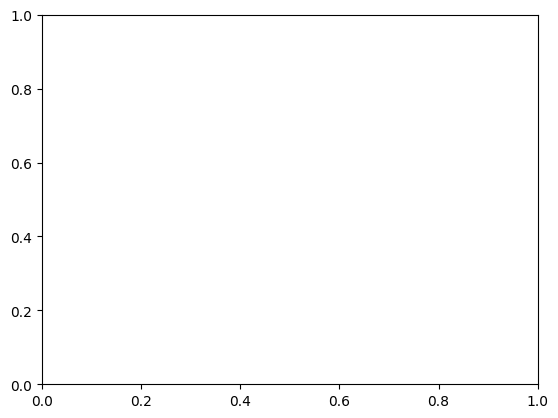

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from tqdm import tqdm

# Step 1: Load dataset
df = pd.read_csv("Sales_Data.csv")

# Step 2: Parse date
df['SALES_WEEK'] = pd.to_datetime(df['SALES_WEEK'], dayfirst=True, errors='coerce')

# Step 3: Remove NA and sort
df = df.dropna(subset=['SALES_WEEK'])
df = df.sort_values(by='SALES_WEEK')

# Step 4: Aggregate ACTUAL by week
weekly_sales = df.groupby('SALES_WEEK')['ACTUAL'].sum().reset_index()

# Step 5: Resample to weekly time series
ts_data = weekly_sales.set_index('SALES_WEEK')['ACTUAL'].resample('W').sum().interpolate()

# Step 6: KPSS test for stationarity
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    if p_value < 0.05:
        print("Series is likely non-stationary.")
    else:
        print("Series is likely stationary.")

kpss_test(ts_data, regression='c')

# Step 7: ACF and PACF plots
plot_acf(ts_data, lags=50)
plt.title("ACF Plot")
plt.show()

plot_pacf(ts_data, lags=30)
plt.title("PACF Plot")
plt.show()

# Step 8: Grid search ARIMA(p,d,q)
results = []
best_model = None
best_aic = np.inf

max_p, max_d, max_q = 5, 2, 5

print("Fitting ARIMA models...")
for p in range(max_p + 1):
    for d in range(max_d + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(ts_data, order=(p, d, q))
                model_fit = model.fit()
                results.append({'p': p, 'd': d, 'q': q, 'AIC': model_fit.aic})
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
            except:
                continue

# Step 9: Best model
results_df = pd.DataFrame(results)
best_order = results_df.loc[results_df['AIC'].idxmin()]
print(f"\nBest ARIMA order: ({int(best_order['p'])}, {int(best_order['d'])}, {int(best_order['q'])}) with AIC = {best_aic}")

# Step 10: Forecast next 16 weeks
forecast_steps = 16
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_index = pd.date_range(start=ts_data.index[-1] + timedelta(days=7), periods=forecast_steps, freq='W')

# Step 11: Combine actual and forecast
actual_df = ts_data.reset_index().rename(columns={'ACTUAL': 'Sales'})
forecast_df = pd.DataFrame({'SALES_WEEK': forecast_index, 'Sales': forecast_mean})
combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)

# Step 12: Plot actual + forecast
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='SALES_WEEK', y='Sales', label='Actual + Forecast', color='blue')
sns.scatterplot(data=forecast_df, x='SALES_WEEK', y='Sales', color='red', label='Forecast Points')
plt.title(f"ARIMA({int(best_order['p'])},{int(best_order['d'])},{int(best_order['q'])}) Forecast (No Log Transform)")
plt.xlabel("Date")
plt.ylabel("Sales (ACTUAL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KPSS Statistic: 0.1680520524192154
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
✅ Series is likely stationary.
Using 9 lags for ACF and PACF plots


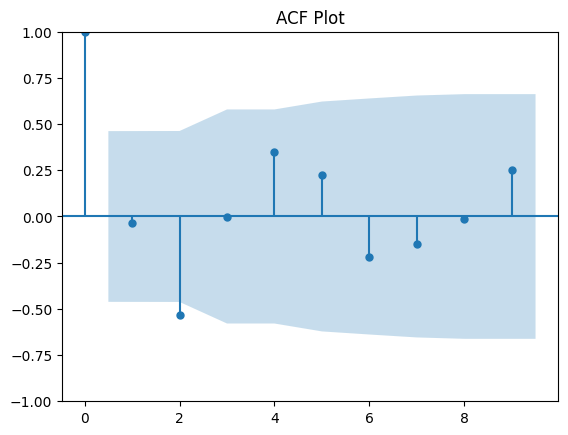

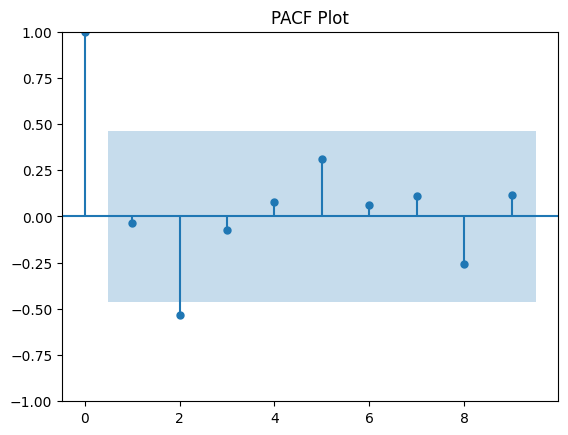

🔄 Fitting ARIMA models...

✅ Best ARIMA order: (2, 0, 0) with AIC = 399.2647414578225


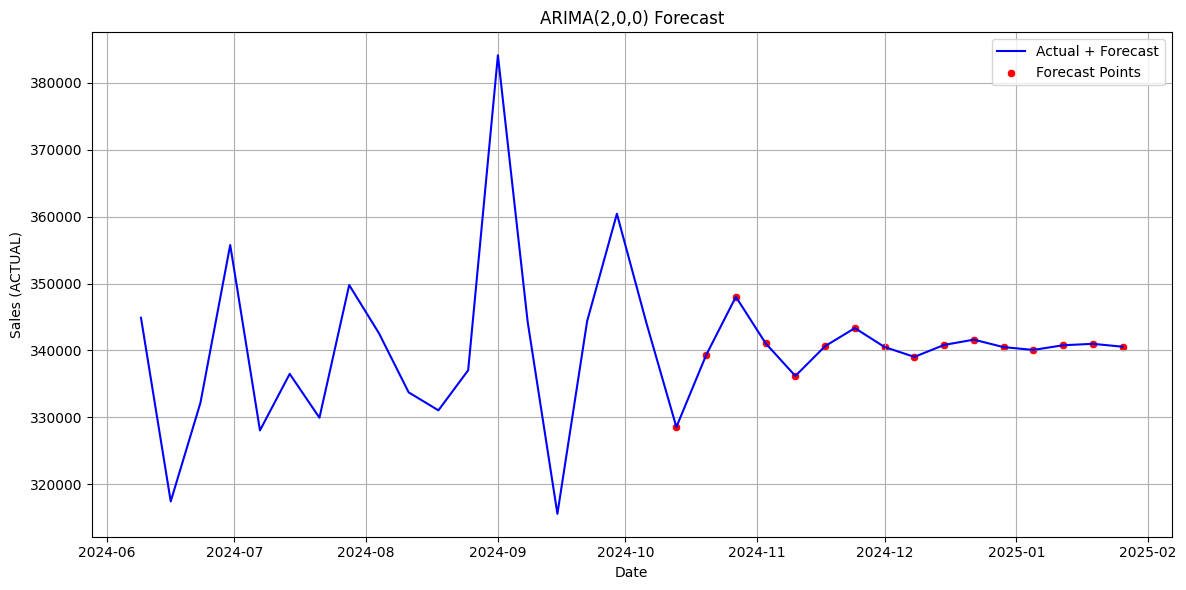

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from tqdm import tqdm

# Step 1: Load dataset
df = pd.read_csv("Sales_Data.csv")

# Step 2: Parse date
df['SALES_WEEK'] = pd.to_datetime(df['SALES_WEEK'], dayfirst=True, errors='coerce')

# Step 3: Remove NA and sort
df = df.dropna(subset=['SALES_WEEK'])
df = df.sort_values(by='SALES_WEEK')

# Step 4: Aggregate ACTUAL by week
weekly_sales = df.groupby('SALES_WEEK')['ACTUAL'].sum().reset_index()

# Step 5: Resample to weekly time series and interpolate
ts_data = weekly_sales.set_index('SALES_WEEK')['ACTUAL'].resample('W').sum().interpolate()

# Step 6: KPSS test for stationarity
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    if p_value < 0.05:
        print("❌ Series is likely non-stationary.")
    else:
        print("✅ Series is likely stationary.")

kpss_test(ts_data, regression='c')

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress ARIMA warnings for clean grid search
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ConvergenceWarning)

# Step 7: ACF and PACF plots with safe lag selection
n_obs = len(ts_data)
max_lags = min(30, n_obs // 2)
print(f"Using {max_lags} lags for ACF and PACF plots")

plot_acf(ts_data, lags=max_lags)
plt.title("ACF Plot")
plt.show()

plot_pacf(ts_data, lags=max_lags)
plt.title("PACF Plot")
plt.show()

# Step 8: Grid search ARIMA(p,d,q)
results = []
best_model = None
best_aic = np.inf

max_p, max_d, max_q = 2, 0, 2

print("🔄 Fitting ARIMA models...")
for p in range(max_p + 1):
    for d in range(max_d + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(ts_data, order=(p, d, q))
                model_fit = model.fit()
                results.append({'p': p, 'd': d, 'q': q, 'AIC': model_fit.aic})
                if model_fit.aic < best_aic:
                    best_aic = model_fit.aic
                    best_model = model_fit
            except:
                continue

# Step 9: Best model
results_df = pd.DataFrame(results)
best_order = results_df.loc[results_df['AIC'].idxmin()]
print(f"\n✅ Best ARIMA order: ({int(best_order['p'])}, {int(best_order['d'])}, {int(best_order['q'])}) with AIC = {best_aic}")

# Step 10: Forecast next 16 weeks
forecast_steps = 16
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_index = pd.date_range(start=ts_data.index[-1] + timedelta(days=7), periods=forecast_steps, freq='W')

# Step 11: Combine actual and forecast
actual_df = ts_data.reset_index().rename(columns={'ACTUAL': 'Sales'})
forecast_df = pd.DataFrame({'SALES_WEEK': forecast_index, 'Sales': forecast_mean})
combined_df = pd.concat([actual_df, forecast_df], ignore_index=True)

# Step 12: Plot actual + forecast
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x='SALES_WEEK', y='Sales', label='Actual + Forecast', color='blue')
sns.scatterplot(data=forecast_df, x='SALES_WEEK', y='Sales', color='red', label='Forecast Points')
plt.title(f"ARIMA({int(best_order['p'])},{int(best_order['d'])},{int(best_order['q'])}) Forecast")
plt.xlabel("Date")
plt.ylabel("Sales (ACTUAL)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
